In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.optimize import minimize_scalar

import nengo
import nengo_brainstorm as brd
from nengo_brainstorm.config import add_params
from nengolib.signal import nrmse

In [3]:
def go(dac_syn_lk=10, dt=0.001, length=1000, freq=10,
       radius=1, seed=0, n_neurons=64, syn_probe=nengo.Lowpass(0.01),
       solver=nengo.solvers.LstsqL2(reg=1e-3), function=lambda x: x,
       bounds=(0, 0.1), maxiter=100):
    
    u_array = nengo.processes.WhiteSignal(
        period=length*dt, high=freq, y0=0, seed=seed).run_steps(length, dt=dt)
    u_array *= radius / np.max(np.abs(u_array))

    with nengo.Network() as model:
        add_params(model)
        model.config[model].dac_syn_lk = dac_syn_lk
        
        # TODO: What is necessary to set dac_syn_lk reliably?
        from pystorm.hal import HAL
        from pystorm.PyDriver import bddriver
        hal = HAL()
        for _ in range(10):
            hal.driver.SetDACCount(
                0, bddriver.bdpars.BDHornEP.DAC_SYN_LK, dac_syn_lk)
        
        u = nengo.Node(output=nengo.processes.PresentInput(u_array, dt))
        x = nengo.Ensemble(n_neurons=n_neurons, dimensions=1)
        
        nengo.Connection(u, x, synapse=None)  # synapse determined by brd
        
        p_spikes = nengo.Probe(x.neurons, 'spikes', synapse=None)

    with brd.Simulator(model, dt=dt, precompute_inputs=True) as sim:
        sim.run(length*dt)

    runs = []
    def objective_function(
            tau, verbose=False,
            a=syn_probe.filt(sim.data[p_spikes], y0=0, dt=dt)):
        y_ideal = syn_probe.filt(function(
            nengo.Lowpass(tau).filt(u_array, y0=0, dt=dt)), y0=0, dt=dt)
        d, _ = solver(a, y_ideal)
        y_hat = a.dot(d)
        e = nrmse(y_hat, target=y_ideal)

        if verbose:
            plt.figure()
            plt.title(r"$\tau = %f \mapsto NRMSE = %f$" % (tau, e))
            plt.plot(sim.trange(), u_array, label=r"$u$")
            plt.plot(sim.trange(), y_ideal, label=r"$y$")
            plt.plot(sim.trange(), y_hat, label=r"$\hat{y}$")
            plt.legend()
            plt.xlabel("Time (s)")
            plt.show()

        runs.append((tau, e))
        return e

    # Method 1: Scipy Bounded optimization
    #opt = minimize_scalar(
    #    objective_function, bounds=bounds, method='bounded',
    #    args=(False,), options={'maxiter': maxiter})

    # Method 2: Linear sweep
    for tau in np.linspace(*bounds, maxiter):
        objective_function(tau)
    from collections import namedtuple
    MockOpt = namedtuple('MockOpt', ['x', 'fun', 'success'])
    i = np.argmin(r_i[1] for r_i in runs)
    opt = MockOpt(runs[i][0], runs[i][1], True)

    return opt, runs

In [4]:
lks = list(range(0, 64))
r = []
for lk in lks:
    opt, runs = go(lk)
    print("dac_syn_lk=%s =>\n%s" % (lk, opt))
    r.append((opt, runs))

HAL: clearing hardware state
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=0 =>
MockOpt(x=0.0, fun=0.5036108799135975, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=1 =>
MockOpt(x=0.0, fun=0.4525023449650095, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=2 =>
MockOpt(x=0.0, fun=0.4414094782190783, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=3 =>
MockOpt(x=0.0, fun=0.5301456269456357, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=4 =>
MockOpt(x=0.0, fun=0.46839353910923764, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=5 =>
MockOpt(x=0.0, fun=0.41037297854558985, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=6 =>
MockOpt(x=0.0, fun=0.5175447089074913, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=7 =>
MockOpt(x=0.0, fun=0.4488505233952754, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=8 =>
MockOpt(x=0.0, fun=0.4822798629503092, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=9 =>
MockOpt(x=0.0, fun=0.5305656184443023, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=10 =>
MockOpt(x=0.0, fun=0.4233641669221804, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=11 =>
MockOpt(x=0.0, fun=0.47369528837334823, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=12 =>
MockOpt(x=0.0, fun=0.46058226710736927, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=13 =>
MockOpt(x=0.0, fun=0.49621872327095234, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=14 =>
MockOpt(x=0.0, fun=0.4202155272264203, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=15 =>
MockOpt(x=0.0, fun=0.5166538231956767, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=16 =>
MockOpt(x=0.0, fun=0.439399624403994, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=17 =>
MockOpt(x=0.0, fun=0.5067063076188496, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=18 =>
MockOpt(x=0.0, fun=0.5033094614703546, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=19 =>
MockOpt(x=0.0, fun=0.4151642240417264, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=20 =>
MockOpt(x=0.0, fun=0.5042482304733533, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=21 =>
MockOpt(x=0.0, fun=0.5191640759827693, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=22 =>
MockOpt(x=0.0, fun=0.43884526204601443, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=23 =>
MockOpt(x=0.0, fun=0.4645147599993497, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=24 =>
MockOpt(x=0.0, fun=0.4416811512975214, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=25 =>
MockOpt(x=0.0, fun=0.49862511984467534, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=26 =>
MockOpt(x=0.0, fun=0.43642160761627335, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=27 =>
MockOpt(x=0.0, fun=0.4763304236118632, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=28 =>
MockOpt(x=0.0, fun=0.4877136129744584, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=29 =>
MockOpt(x=0.0, fun=0.47475837475083404, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=30 =>
MockOpt(x=0.0, fun=0.48272299936046953, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=31 =>
MockOpt(x=0.0, fun=0.45384688013915103, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=32 =>
MockOpt(x=0.0, fun=0.4601837688619874, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=33 =>
MockOpt(x=0.0, fun=0.48729134878498936, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=34 =>
MockOpt(x=0.0, fun=0.5320219947162941, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=35 =>
MockOpt(x=0.0, fun=0.5136113959864301, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=36 =>
MockOpt(x=0.0, fun=0.3869563086527218, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=37 =>
MockOpt(x=0.0, fun=0.4217802092560922, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=38 =>
MockOpt(x=0.0, fun=0.40395217622156226, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=39 =>
MockOpt(x=0.0, fun=0.46655891937454946, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=40 =>
MockOpt(x=0.0, fun=0.4066181163990904, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=41 =>
MockOpt(x=0.0, fun=0.45512443789282714, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=42 =>
MockOpt(x=0.0, fun=0.45504807681002235, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=43 =>
MockOpt(x=0.0, fun=0.4519743338680377, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=44 =>
MockOpt(x=0.0, fun=0.511677725945844, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=45 =>
MockOpt(x=0.0, fun=0.41484960824509803, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=46 =>
MockOpt(x=0.0, fun=0.43108477675498974, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=47 =>
MockOpt(x=0.0, fun=0.4519213672360495, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=48 =>
MockOpt(x=0.0, fun=0.44478240835478977, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=49 =>
MockOpt(x=0.0, fun=0.4804809318863277, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=50 =>
MockOpt(x=0.0, fun=0.4993934802165277, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=51 =>
MockOpt(x=0.0, fun=0.45090662112163266, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=52 =>
MockOpt(x=0.0, fun=0.4287991913839554, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=53 =>
MockOpt(x=0.0, fun=0.514538427552233, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=54 =>
MockOpt(x=0.0, fun=0.41796112580505757, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=55 =>
MockOpt(x=0.0, fun=0.4350620021300728, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=56 =>
MockOpt(x=0.0, fun=0.4714944487020998, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=57 =>
MockOpt(x=0.0, fun=0.5074138203068569, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=58 =>
MockOpt(x=0.0, fun=0.516599920748619, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=59 =>
MockOpt(x=0.0, fun=0.511712191281965, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=60 =>
MockOpt(x=0.0, fun=0.5295239130016088, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=61 =>
MockOpt(x=0.0, fun=0.4741688480769369, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=62 =>
MockOpt(x=0.0, fun=0.5093947378419273, success=True)
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
dac_syn_lk=63 =>
MockOpt(x=0.0, fun=0.536829444606576, success=True)


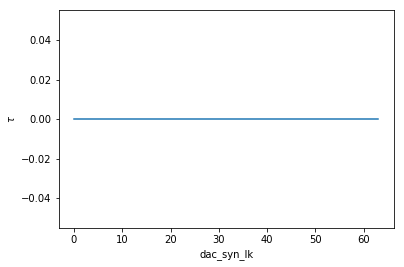

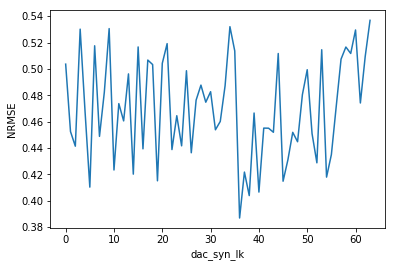

In [5]:
plt.figure()
plt.plot(lks, [r_i[0].x for r_i in r])
plt.xlabel("dac_syn_lk")
plt.ylabel(r"$\tau$")
plt.show()

plt.figure()
plt.plot(lks, [r_i[0].fun for r_i in r])
plt.xlabel("dac_syn_lk")
plt.ylabel(r"NRMSE")
plt.show()

assert np.all(r_i[0].success for r_i in r)

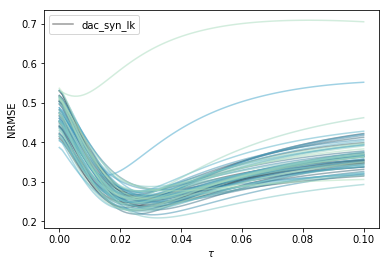

In [6]:
plt.figure()
for i, (c, r_i) in enumerate(zip(sns.color_palette('GnBu_d', len(r)), r)):
    plt.plot(*np.asarray(r_i[1]).T, c=c, alpha=0.5,
             label=None if i else "dac_syn_lk")
plt.xlabel(r"$\tau$")
plt.ylabel("NRMSE")
plt.legend()
plt.show()

In [7]:
#from pystorm.hal import HAL; hal = HAL(); hal.stop_hardware()